In [0]:
import numpy as np
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Obtain the train and test data

In [0]:
train = pd.read_csv('/content/gdrive/My Drive/Journal Paper/Human Activity Detection/UCI HAR Dataset/csv_files/train.csv')
test = pd.read_csv('/content/gdrive/My Drive/Journal Paper/Human Activity Detection/UCI HAR Dataset/csv_files/test.csv')
print(train.shape, test.shape)



(7352, 564) (2947, 564)


In [0]:
train.head(3)

,1tBodyAccmeanX,2tBodyAccmeanY,3tBodyAccmeanZ,4tBodyAccstdX,5tBodyAccstdY,6tBodyAccstdZ,7tBodyAccmadX,8tBodyAccmadY,9tBodyAccmadZ,10tBodyAccmaxX,11tBodyAccmaxY,12tBodyAccmaxZ,13tBodyAccminX,14tBodyAccminY,15tBodyAccminZ,16tBodyAccsma,17tBodyAccenergyX,18tBodyAccenergyY,19tBodyAccenergyZ,20tBodyAcciqrX,21tBodyAcciqrY,22tBodyAcciqrZ,23tBodyAccentropyX,24tBodyAccentropyY,25tBodyAccentropyZ,26tBodyAccarCoeffX1,27tBodyAccarCoeffX2,28tBodyAccarCoeffX3,29tBodyAccarCoeffX4,30tBodyAccarCoeffY1,31tBodyAccarCoeffY2,32tBodyAccarCoeffY3,33tBodyAccarCoeffY4,34tBodyAccarCoeffZ1,35tBodyAccarCoeffZ2,36tBodyAccarCoeffZ3,37tBodyAccarCoeffZ4,38tBodyAcccorrelationXY,39tBodyAcccorrelationXZ,40tBodyAcccorrelationYZ,...,525fBodyBodyAccJerkMagmaxInds,526fBodyBodyAccJerkMagmeanFreq,527fBodyBodyAccJerkMagskewness,528fBodyBodyAccJerkMagkurtosis,529fBodyBodyGyroMagmean,530fBodyBodyGyroMagstd,531fBodyBodyGyroMagmad,532fBodyBodyGyroMagmax,533fBodyBodyGyroMagmin,534fBodyBodyGyroMagsma,535fBodyBodyGyroMagenergy,536fBodyBodyGyroMagiqr,537fBodyBodyGyroMagentropy,538fBodyBodyGyroMagmaxInds,539fBodyBodyGyroMagmeanFreq,540fBodyBodyGyroMagskewness,541fBodyBodyGyroMagkurtosis,542fBodyBodyGyroJerkMagmean,543fBodyBodyGyroJerkMagstd,544fBodyBodyGyroJerkMagmad,545fBodyBodyGyroJerkMagmax,546fBodyBodyGyroJerkMagmin,547fBodyBodyGyroJerkMagsma,548fBodyBodyGyroJerkMagenergy,549fBodyBodyGyroJerkMagiqr,550fBodyBodyGyroJerkMagentropy,551fBodyBodyGyroJerkMagmaxInds,552fBodyBodyGyroJerkMagmeanFreq,553fBodyBodyGyroJerkMagskewness,554fBodyBodyGyroJerkMagkurtosis,555angletBodyAccMeangravity,556angletBodyAccJerkMeangravityMean,557angletBodyGyroMeangravityMean,558angletBodyGyroJerkMeangravityMean,559angleXgravityMean,560angleYgravityMean,561angleZgravityMean,subject,Activity,ActivityName
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0.794872,-0.212728,-0.535352,-0.871914,-0.995031,-0.995127,-0.994640,-0.996060,-0.995866,-0.995031,-0.999973,-0.993755,-1.000000,-0.555556,0.414503,-0.390748,-0.760104,-0.

In [0]:
# get X_train and y_train from csv files
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train.ActivityName

In [0]:
# get X_test and y_test from test csv file
X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test.ActivityName

In [0]:
print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((7352, 561),(7352,))
X_test  and y_test  : ((2947, 561),(2947,))


# Let's model with our data

### Labels that are useful in plotting confusion matrix

In [0]:
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

### Function to plot the confusion matrix

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Generic function to run any model specified

In [0]:
from datetime import datetime
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results
    
    

### Function to plot Train and Test AUC Curve

In [0]:
from sklearn.metrics import roc_curve, auc

def best_model(model, X_train, Y_train, X_test, Y_test):
  classifier = model.best_estimator_
  print(classifier)
  classifier.fit(X_train, Y_train)

  try:
    y_train_pred = classifier.predict_proba(X_train)[:,1]
    y_test_pred = classifier.predict_proba(X_test)[:,1]
  except:
    y_train_pred = classifier.decision_function(X_train)
    y_test_pred = classifier.decision_function(X_test)

  train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
  test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

  ### --- This is test AUC for TFIDF
  auc_bow = auc(test_fpr, test_tpr)

  plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.title("ERROR PLOTS")
  plt.grid()
  plt.show()

### Method to print the gridsearch Attributes

In [0]:
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('--------------------------')
    print('|      Best Estimator     |')
    print('--------------------------')
    print('\n\t{}\n'.format(model.best_estimator_))


    # parameters that gave best results while performing grid search
    print('--------------------------')
    print('|     Best parameters     |')
    print('--------------------------')
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))


    #  number of cross validation splits
    print('---------------------------------')
    print('|   No of CrossValidation sets   |')
    print('--------------------------------')
    print('\n\tTotal numbre of cross validation sets: {}\n'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search 
    print('--------------------------')
    print('|        Best Score       |')
    print('--------------------------')
    print('\n\tAverage Cross Validate scores of best estimator : \n\n\t{}\n'.format(model.best_score_))

    
    

# 1. Logistic Regression with Grid Search

In [0]:
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

In [0]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('X_train_scaled and y_train : ({},{})'.format(X_train_scaled.shape, y_train.shape))
print('X_test_scaled and y_test  : ({},{})'.format(X_test_scaled.shape, y_test.shape))

X_train_scaled and y_train : ((7352, 561),(7352,))
X_test_scaled and y_test  : ((2947, 561),(2947,))


training the model..
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Done 
 

training_time(HH:MM:SS.ms) - 0:01:25.202157


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.008991


---------------------
|      Accuracy      |
---------------------

    0.9602986087546658


--------------------
| Confusion Matrix |
--------------------

 [[537   0   0   0   0   0]
 [  1 432  55   0   0   3]
 [  0  13 519   0   0   0]
 [  0   0   0 495   0   1]
 [  0   0   0   5 403  12]
 [  0   0   0  25   2 444]]


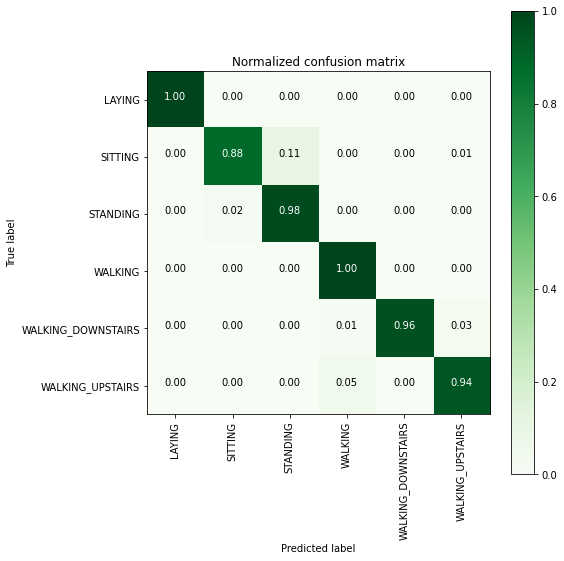

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.88      0.92       491
          STANDING       0.90      0.98      0.94       532
           WALKING       0.94      1.00      0.97       496
WALKING_DOWNSTAIRS       1.00      0.96      0.98       420
  WALKING_UPSTAIRS       0.97      0.94      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



In [0]:

# start Grid search
parameters_LR = {'C':[0.01, 0.1, 1, 10, 20, 30], 'penalty':['l2','l1']}
log_reg = linear_model.LogisticRegression(max_iter=300)
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters_LR, cv=3, verbose=1, return_train_score=True, n_jobs=-1)
log_reg_grid_results =  perform_model(log_reg_grid, X_train, y_train, X_test, y_test, class_labels=labels)

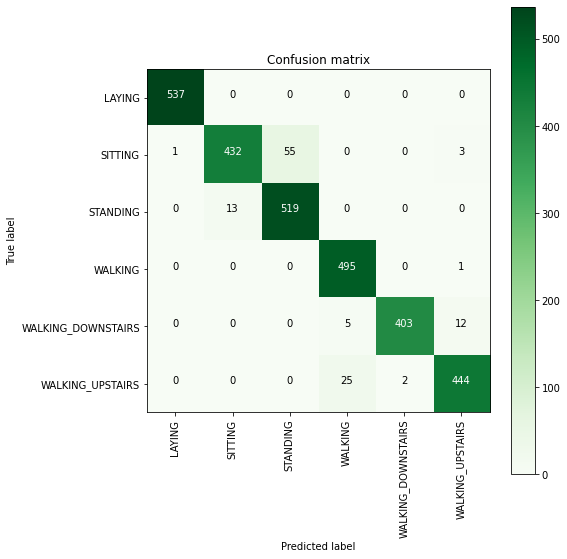

In [0]:
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(log_reg_grid_results['confusion_matrix'], classes=labels, cmap=plt.cm.Greens, )
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


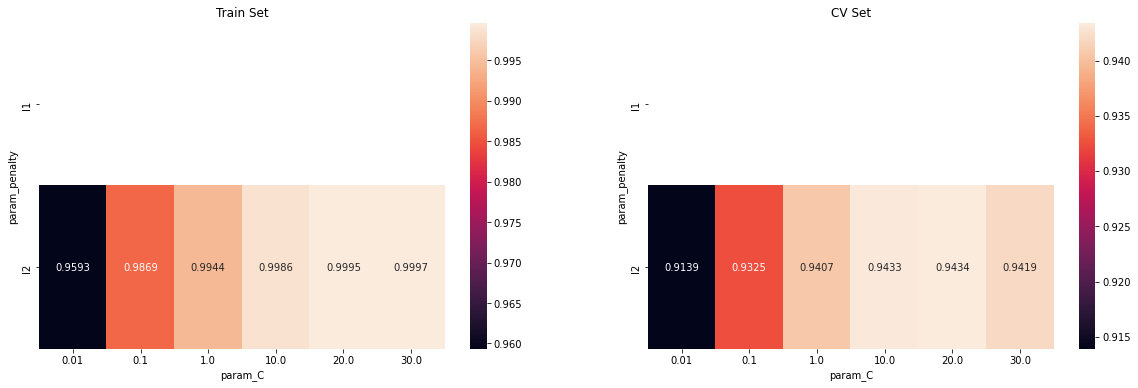

In [0]:
import seaborn as sns

max_scores = pd.DataFrame(log_reg_grid.cv_results_).groupby(['param_penalty','param_C']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()

In [0]:
# observe the attributes of the model 
print_grid_search_attributes(log_reg_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 20, 'penalty': 'l2'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9434189571381388



In [0]:
print(log_reg_grid.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [0]:
# ModelBest = log_reg_grid.best_estimator_
# classifier = ModelBest
# classifier.fit(X_train_scaled, y_train) 

In [0]:
y_train_pred = classifier.predict_proba(X_train_scaled)
print(y_train_pred.shape)

(7352, 6)


In [0]:
# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# y_train_dummies = pd.get_dummies(y_train, drop_first=False).values

# for i in range(6):
#     fpr[i], tpr[i],_ = roc_curve(y_train_dummies[:, i], y_train_pred[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # roc for each class
# fig, ax = plt.subplots(figsize=(17, 6))
# ax.plot([0, 1], [0, 1], 'k--')
# ax.set_xlim([0.0, 1.0])
# ax.set_ylim([0.0, 1.05])
# ax.set_xlabel('False Positive Rate')
# ax.set_ylabel('True Positive Rate')
# ax.set_title('Receiver operating characteristic example')
# for i in range(6):
#     ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
# ax.legend(loc="best")
# ax.grid(alpha=.4)
# sns.despine()
# plt.show()

In [0]:
# best_model(log_reg_grid, X_train_scaled, y_train, X_test_scaled, y_test)

#  2. Linear SVC with GridSearch

In [0]:
from sklearn.svm import LinearSVC

training the model..
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 
 

training_time(HH:MM:SS.ms) - 0:01:33.248797


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.009400


---------------------
|      Accuracy      |
---------------------

    0.9657278588394977


--------------------
| Confusion Matrix |
--------------------

 [[537   0   0   0   0   0]
 [  2 425  60   0   0   4]
 [  0  10 521   1   0   0]
 [  0   0   0 496   0   0]
 [  0   0   0   2 413   5]
 [  0   0   0  17   0 454]]


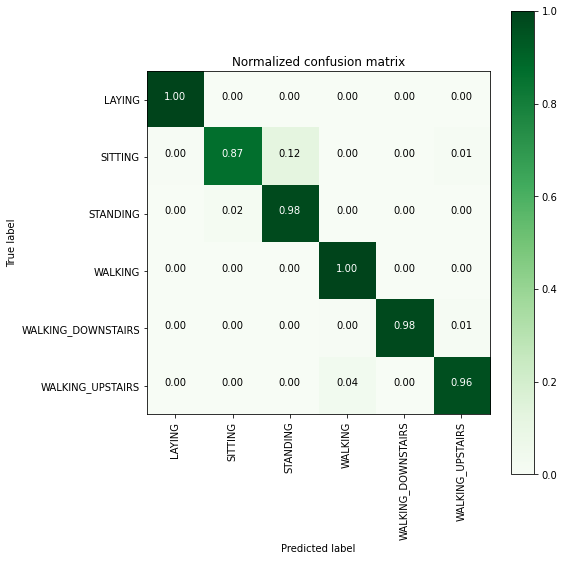

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.98      0.87      0.92       491
          STANDING       0.90      0.98      0.94       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
  WALKING_UPSTAIRS       0.98      0.96      0.97       471

          accuracy                           0.97      2947
         macro avg       0.97      0.97      0.97      2947
      weighted avg       0.97      0.97      0.97      2947



In [0]:
parameters_LSVC = {'C':[0.125, 0.5, 1, 2, 8, 16]}
lr_svc = LinearSVC(tol=0.00005)
lr_svc_grid = GridSearchCV(lr_svc, param_grid=parameters_LSVC, n_jobs=-1, verbose=1, return_train_score=True)
lr_svc_grid_results = perform_model(lr_svc_grid, X_train, y_train, X_test, y_test, class_labels=labels)

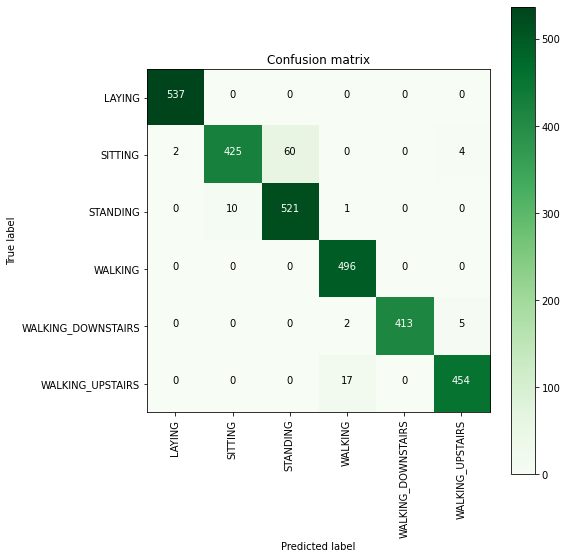

In [0]:
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(lr_svc_grid_results['confusion_matrix'], classes=labels, cmap=plt.cm.Greens, )
plt.show()

In [0]:
print_grid_search_attributes(lr_svc_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=5e-05,
          verbose=0)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 1}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9424721023691598



# 3.  Kernel SVM with GridSearch

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:13:09.110753


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:03.031578


---------------------
|      Accuracy      |
---------------------

    0.9626739056667798


--------------------
| Confusion Matrix |
--------------------

 [[537   0   0   0   0   0]
 [  0 441  48   0   0   2]
 [  0  12 520   0   0   0]
 [  0   0   0 489   2   5]
 [  0   0   0   4 397  19]
 [  0   0   0  17   1 453]]


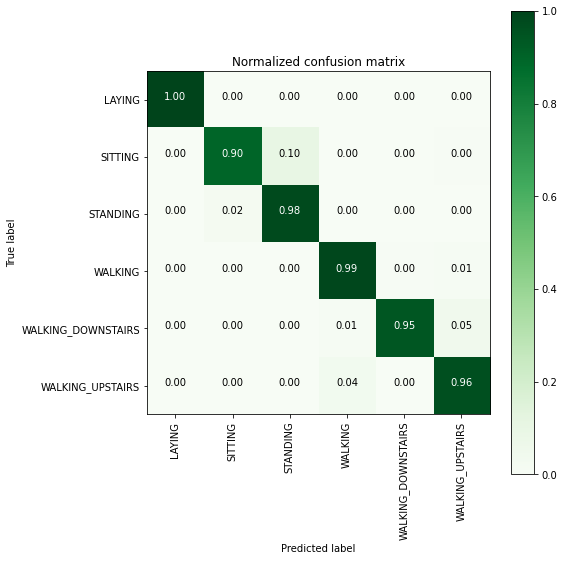

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.90      0.93       491
          STANDING       0.92      0.98      0.95       532
           WALKING       0.96      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.95      0.96      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



In [0]:
from sklearn.svm import SVC
parameters_ksvm = {'C':[2,8,16],\
              'gamma': [ 0.0078125, 0.125, 2]}
rbf_svm = SVC(kernel='rbf')
rbf_svm_grid = GridSearchCV(rbf_svm,param_grid=parameters_ksvm, n_jobs=-1)
rbf_svm_grid_results = perform_model(rbf_svm_grid, X_train, y_train, X_test, y_test, class_labels=labels)

In [0]:
print_grid_search_attributes(rbf_svm_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	SVC(C=16, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0078125, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 16, 'gamma': 0.0078125}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9447834551903698



# 4. Decision Trees with GridSearchCV

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:33.949317


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.020404


---------------------
|      Accuracy      |
---------------------

    0.8734306073973532


--------------------
| Confusion Matrix |
--------------------

 [[537   0   0   0   0   0]
 [  0 370 121   0   0   0]
 [  0  59 473   0   0   0]
 [  0   0   0 474  17   5]
 [  0   0   0  26 349  45]
 [  0   0   0  65  35 371]]


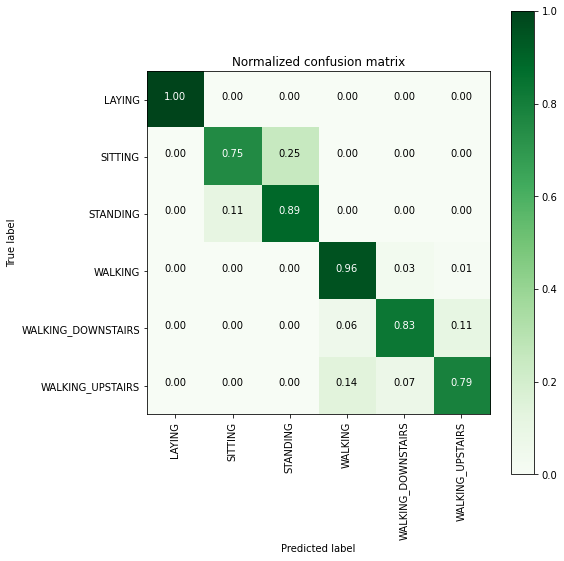

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.86      0.75      0.80       491
          STANDING       0.80      0.89      0.84       532
           WALKING       0.84      0.96      0.89       496
WALKING_DOWNSTAIRS       0.87      0.83      0.85       420
  WALKING_UPSTAIRS       0.88      0.79      0.83       471

          accuracy                           0.87      2947
         macro avg       0.87      0.87      0.87      2947
      weighted avg       0.88      0.87      0.87      2947

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
          

In [0]:
from sklearn.tree import DecisionTreeClassifier
parameters_DT = {'max_depth':np.arange(3,10,2)}
dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt,param_grid=parameters_DT, n_jobs=-1)
dt_grid_results = perform_model(dt_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(dt_grid_results['model'])

In [0]:
print_grid_search_attributes(dt_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'max_depth': 9}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.8512056678551774



# 5. Random Forest Classifier with GridSearch

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:24:19.412111


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.060949


---------------------
|      Accuracy      |
---------------------

    0.9205972175093315


--------------------
| Confusion Matrix |
--------------------

 [[537   0   0   0   0   0]
 [  0 431  60   0   0   0]
 [  0  50 482   0   0   0]
 [  0   0   0 483   7   6]
 [  0   0   0  29 351  40]
 [  0   0   0  36   6 429]]


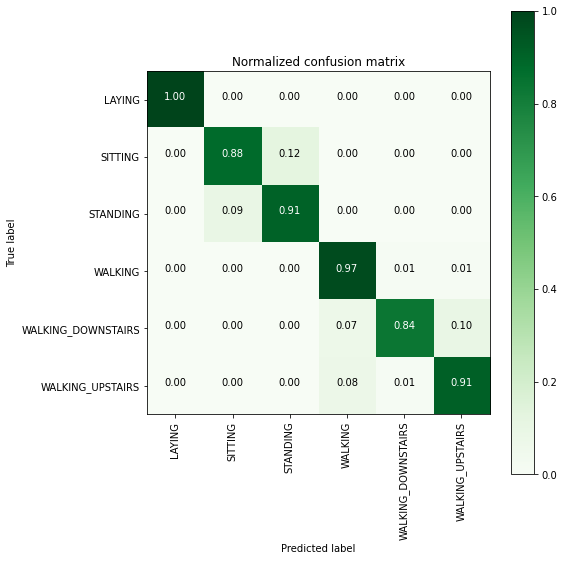

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.90      0.88      0.89       491
          STANDING       0.89      0.91      0.90       532
           WALKING       0.88      0.97      0.93       496
WALKING_DOWNSTAIRS       0.96      0.84      0.90       420
  WALKING_UPSTAIRS       0.90      0.91      0.91       471

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947

--------------------------
|      Best Estimator     |
--------------------------

	RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min

In [0]:
from sklearn.ensemble import RandomForestClassifier
params_RF = {'n_estimators': np.arange(10,201,20), 'max_depth':np.arange(3,15,2)}
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, param_grid=params_RF, n_jobs=-1)
rfc_grid_results = perform_model(rfc_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(rfc_grid_results['model'])

# 6.  Gradient Boosted Decision Trees With GridSearch

In [0]:
# from sklearn.ensemble import GradientBoostingClassifier
# param_grid_GBDT = {'max_depth': np.arange(5,8,1), \
#              'n_estimators':np.arange(130,170,10)}
# gbdt = GradientBoostingClassifier()
# gbdt_grid = GridSearchCV(gbdt, param_grid=param_grid_GBDT, n_jobs=-1)
# gbdt_grid_results = perform_model(gbdt_grid, X_train, y_train, X_test, y_test, class_labels=labels)
# print_grid_search_attributes(gbdt_grid_results['model'])

# 7. Light GBM with GridSearch

training the model..
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 24.4min finished


Done 
 

training_time(HH:MM:SS.ms) - 0:24:28.612372


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.052051


---------------------
|      Accuracy      |
---------------------

    0.8982015609093994


--------------------
| Confusion Matrix |
--------------------

 [[537   0   0   0   0   0]
 [  0 391  96   0   0   4]
 [  0  56 474   0   0   2]
 [  0   0   0 485   9   2]
 [  0   0   0  28 343  49]
 [  0   1   0  46   7 417]]


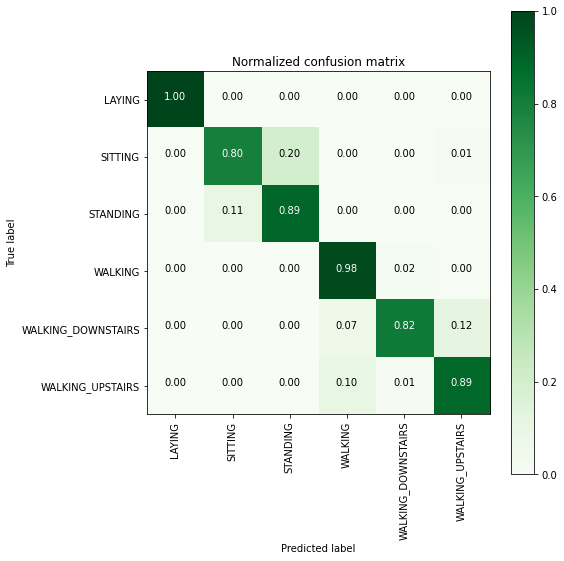

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.87      0.80      0.83       491
          STANDING       0.83      0.89      0.86       532
           WALKING       0.87      0.98      0.92       496
WALKING_DOWNSTAIRS       0.96      0.82      0.88       420
  WALKING_UPSTAIRS       0.88      0.89      0.88       471

          accuracy                           0.90      2947
         macro avg       0.90      0.89      0.90      2947
      weighted avg       0.90      0.90      0.90      2947

--------------------------
|      Best Estimator     |
--------------------------

	LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
     

In [0]:
from lightgbm import LGBMClassifier
parameters_lgbm = {'max_depth': [1, 5, 10, 50], 'n_estimators':np.arange(10,121,20)}

lgbm = LGBMClassifier()
lgbm_grid = GridSearchCV(lgbm,param_grid=parameters_lgbm, cv=3, verbose=1, n_jobs=-1, return_train_score=True)
lgbm_grid_results = perform_model(lgbm_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(lgbm_grid_results['model'])

# 8. XGBoost with GridSearch

training the model..
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 68.8min finished


Done 
 

training_time(HH:MM:SS.ms) - 1:12:08.747827


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.166206


---------------------
|      Accuracy      |
---------------------

    0.9362063115032236


--------------------
| Confusion Matrix |
--------------------

 [[537   0   0   0   0   0]
 [  0 419  72   0   0   0]
 [  0  33 499   0   0   0]
 [  0   0   0 489   5   2]
 [  0   0   0  10 381  29]
 [  0   0   0  31   6 434]]


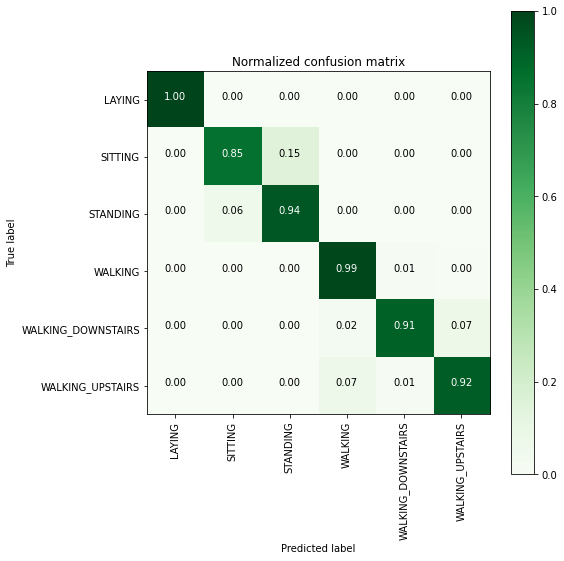

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.93      0.85      0.89       491
          STANDING       0.87      0.94      0.90       532
           WALKING       0.92      0.99      0.95       496
WALKING_DOWNSTAIRS       0.97      0.91      0.94       420
  WALKING_UPSTAIRS       0.93      0.92      0.93       471

          accuracy                           0.94      2947
         macro avg       0.94      0.93      0.94      2947
      weighted avg       0.94      0.94      0.94      2947

--------------------------
|      Best Estimator     |
--------------------------

	XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missin

In [0]:
from xgboost import XGBClassifier
parameters_xgb = {'max_depth': [1, 5, 10, 50], 'n_estimators':np.arange(10,121,20)}

xgb = XGBClassifier()
xgb_grid = GridSearchCV(xgb,param_grid=parameters_xgb, cv=3, verbose=1, n_jobs=-1, return_train_score=True)
xgb_grid_results = perform_model(xgb_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(xgb_grid_results['model'])

# 9. KNN with Grid Search

training the model..
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 10.6min finished


Done 
 

training_time(HH:MM:SS.ms) - 0:10:38.736855


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:18.177211


---------------------
|      Accuracy      |
---------------------

    0.9046487953851374


--------------------
| Confusion Matrix |
--------------------

 [[535   1   1   0   0   0]
 [  0 389  98   0   0   4]
 [  0  31 501   0   0   0]
 [  0   0   0 488   8   0]
 [  0   0   0  51 328  41]
 [  0   0   0  39   7 425]]


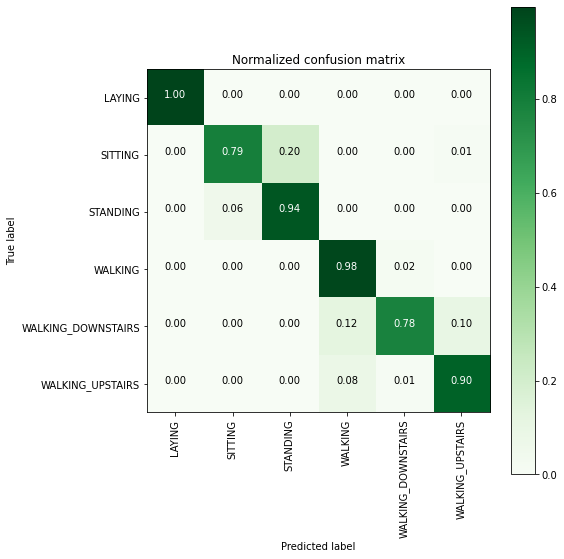

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.92      0.79      0.85       491
          STANDING       0.83      0.94      0.89       532
           WALKING       0.84      0.98      0.91       496
WALKING_DOWNSTAIRS       0.96      0.78      0.86       420
  WALKING_UPSTAIRS       0.90      0.90      0.90       471

          accuracy                           0.90      2947
         macro avg       0.91      0.90      0.90      2947
      weighted avg       0.91      0.90      0.90      2947

--------------------------
|      Best Estimator     |
--------------------------

	KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

--------------------------
|     Best parameter

In [0]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# start Grid search
parameters_KNN = {'n_neighbors':[3, 15, 25, 51, 101, 151, 201, 301, 401]}
KNN_Class = KNeighborsClassifier()
KNN_Class_grid = GridSearchCV(KNN_Class, param_grid=parameters_KNN, cv=3, verbose=1, n_jobs=-1, return_train_score=True)
KNN_Class_grid_results =  perform_model(KNN_Class_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(KNN_Class_grid_results['model'])


# 7. Comparing all models

In [0]:
print('\n                     Accuracy     Error')
print('                     ----------   --------')
print('Logistic Regression : {:.04}%       {:.04}%'.format(log_reg_grid_results['accuracy'] * 100,\
                                                  100-(log_reg_grid_results['accuracy'] * 100)))

print('Linear SVC          : {:.04}%       {:.04}% '.format(lr_svc_grid_results['accuracy'] * 100,\
                                                        100-(lr_svc_grid_results['accuracy'] * 100)))

print('rbf SVM classifier  : {:.04}%      {:.04}% '.format(rbf_svm_grid_results['accuracy'] * 100,\
                                                          100-(rbf_svm_grid_results['accuracy'] * 100)))

print('DecisionTree        : {:.04}%      {:.04}% '.format(dt_grid_results['accuracy'] * 100,\
                                                        100-(dt_grid_results['accuracy'] * 100)))

print('Random Forest       : {:.04}%      {:.04}% '.format(rfc_grid_results['accuracy'] * 100,\
                                                           100-(rfc_grid_results['accuracy'] * 100)))
print('GradientBoosting DT : {:.04}%      {:.04}% '.format(rfc_grid_results['accuracy'] * 100,\
                                                        100-(rfc_grid_results['accuracy'] * 100)))


                     Accuracy     Error
                     ----------   --------
Logistic Regression : 96.27%       3.733%
Linear SVC          : 96.61%       3.393% 
rbf SVM classifier  : 96.27%      3.733% 
DecisionTree        : 86.43%      13.57% 
Random Forest       : 91.31%      8.687% 
GradientBoosting DT : 91.31%      8.687% 


> We can choose ___Logistic regression___ or ___Linear SVC___ or ___rbf SVM___.

# Conclusion :

In the real world, domain-knowledge, EDA and feature-engineering matter most.